In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dot Product Attention
$$
\text{Attention}(Q, K, V) = \text{softmax}\bigg(\dfrac{QK^T}{\sqrt{d_k}}\bigg)V
$$

In [58]:

class DotProductAttention (nn.Module):
    def __init__ (self, dropout=0.4):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)


    def forward (self, Q, K, V, mask=None):
        """
        Args:
            Q: [batch_size, h, seq_len, d_k]
            K: [batch_size, h, seq_len, d_k]
            V: [batch_size, h, seq_len, d_k]
            mask: [batch_size, 1, seq_len, seq_len] (or broadcastable shape)
        Returns:
            output: [batch_size, h, seq_len, d_k]
            attention: [batch_size, h, seq_len, seq_len]
        """

        # dot-product
        KT = torch.transpose(K, -2, -1)
        similarity = torch.matmul(Q, KT)

        # normalisation
        norm_factor = math.sqrt(Q.size(-1)) + 1e-10
        similarity = similarity / norm_factor

        # masking
        if mask is not None:
            similarity = similarity.masked_fill(mask == 0, -1e9)

        # attention weights
        attention = self.softmax(similarity)
        attention = self.dropout(attention)

        # weighted sum
        output = torch.matmul(attention, V)

        # return output and attention
        return output, attention

## Multi-head
$$
\text{MultiHead}(Q, K, V) = \text{concat}(\text{head}_1, \cdots, \text{head}_h)W^O
$$
where
$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$
where $W_i^Q \in \mathbb{R}^{d_{\text{model}}\times d_k}$, $W_i^K \in \mathbb{R}^{d_{\text{model}}\times d_k}$, $W_i^V \in \mathbb{R}^{d_{\text{model}}\times d_v}$ and $W^O \in \mathbb{R}^{hd_{v}\times d_{\text{model}}}$.

We also use $d_k = d_v = d_{\text{model}}/h$.

In [59]:
class MultiHeadAttention (nn.Module):
    def __init__(self, d_model, h, dropout=0.4):
        super().__init__()
        self.d_model = d_model
        self.h = h
        self.d_k = d_model // h

        # self projections
        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)

        # attention layer
        self.attention = DotProductAttention(dropout)

        # output projection
        self.WO = nn.Linear(d_model, d_model)

    def forward (self, X, mask=None):
        # obtain Q, K and V matrices

        # input size is [batch_size, seq_len, d_model]
        # want size [batch_size, h, seq_len, d_model]
        # obtained by [batch_size, seq_len, d_model] -> [batch_size, seq_len, h, d_k] -> [batch_size, h, seq_len, d_k] for contiguity

        batch_size = X.size(0)
        Q = self.WQ(X).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        K = self.WK(X).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        V = self.WV(X).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)

        # calculate attention
        output, attention = self.attention(Q, K, V, mask)


        # concatenate the layers
        # want [batch_size, seq_len, h, d_k] -> [batch_size, seq_len, h*d_k], so take transpose first
        # doing contiguous returns the matrix as contiguous arrays
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # layer normalisation + residual connection
        output = self.WO(output)

        # return output
        return output, attention

In [60]:
d_model, h = 512, 8
model = MultiHeadAttention(d_model, h)
X = torch.randn(2, 10, d_model)
output, _ = model(X)

print(_.shape)
print(output.shape)

torch.Size([2, 8, 10, 10])
torch.Size([2, 10, 512])


## Transformer

$$\begin{align*}
\mathbf{z'}_l &= \text{MSA}(\text{LN}(\mathbf{z_{l-1}})) + \mathbf{z}_{l-1} \\
\mathbf{z}_l &= \text{MLP}(\text{LN}(\mathbf{z'}_l)) + \mathbf{z'}_l
\end{align*}
$$

### Nomenclature

> The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

We assume inputs of size $D$ into the encoder unit, and outputs of the same dimensions. Repeat $L$ times for the transformer.

Here, $\mathbf{z}_l \in \mathbb{R}^{(N+1) \times D}$, where $N$ is the number of patches, i.e., it is equivalent to `seq_len` in an MLA block.


In [61]:
class EncoderUnit (nn.Module):
    def __init__(self, D=768, mlp_ratio=4, msa_dropout=0.4, mlp_dropout=0.4):
        super().__init__()
        self.D = D # dimensions of the vectors everywhere

        # attention
        self.norm_msa = nn.LayerNorm(D, elementwise_affine=False)
        self.msa = MultiHeadAttention(
            D,
            h=8,
            dropout=msa_dropout
        )

        # MLP
        self.norm_mlp = nn.LayerNorm(D, elementwise_affine=False)
        self.mlp = nn.Sequential(
            nn.Linear(D, mlp_ratio*D),  # expand
            nn.GELU(),                    # activation
            nn.Dropout(mlp_dropout),
            nn.Linear(mlp_ratio*D, D),  # project back
            nn.Dropout(mlp_dropout),
        )

    def forward (self, z):
        z_, attention = self.msa(self.norm_msa(z))
        z_attn = z + z_
        z_out = z_attn + self.mlp(self.norm_mlp(z_attn))

        return z_out, attention

In [62]:
class TransformerEncoder (nn.Module):
    def __init__(self, D=768, L=6, mlp_ratio=4, msa_dropout=0.4, mlp_dropout=0.4):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderUnit(
                D,
                mlp_ratio=mlp_ratio,
                msa_dropout=msa_dropout,
                mlp_dropout=mlp_dropout
            ) for _ in  range(L)
        ])

    def forward (self, z):
        for layer in self.layers:
            z, attention = layer(z)
        return z

In [63]:
# Test the encoder unit
D = 768  # ViT-Base hidden dim
encoder = TransformerEncoder(D)
x = torch.randn(1, 197, D)  # [batch, seq_len, D]
output = encoder(x)  # Shape preserved

In [64]:
output.shape
# len(encoder.attentions)

torch.Size([1, 197, 768])

## Patching
Use convolutions to convert image of size $(C, H, W)$ to $(D, \sqrt{N}, \sqrt{N})$, where $N \equiv HW/P^2$ is the number of patches and $P$ is the patch size. This can be flattened to $(D, N)$ and then transposed to get $(N, D)$, as desired.

Remember that the input is actually `[B, C, H, W]`.

In [65]:
class PatchEmbedding (nn.Module):
    def __init__ (self, img_size=224, num_channels=3, embed_dims=768, patch_size=16, pos_embed_type='1d_learned'):
        super().__init__()
        # input image
        self.img_size = img_size
        self.num_channels = num_channels

        # embedding dimensions
        self.embed_dims = embed_dims

        # patches
        self.patch_size = patch_size
        assert img_size % patch_size == 0, "Image dimensions must be divisible by patch size"

        self.num_patches = (img_size // patch_size) ** 2

        # convolution to convert to patches
        self.conv = nn.Conv2d(
            num_channels,
            embed_dims,
            kernel_size=patch_size,
            stride=patch_size,
            bias=False # ViT excludes bias, apparently
        )

        # [CLS] token
        self.cls = nn.Parameter(torch.randn(1, 1, self.embed_dims))

        # learnable position embedding
        self.pos_embed_type = pos_embed_type.lower()
        if self.pos_embed_type == 'none':
            self.pos_embed = None
        elif self.pos_embed_type == '1d_learned':
            # Default ViT learned positional embedding
            self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dims))
        elif self.pos_embed_type == '2d_learned':
            # 2D learned embedding (Appendix D.4)
            grid_size = img_size // patch_size
            self.pos_embed_height = nn.Parameter(torch.randn(1, embed_dims, grid_size, 1))  # For height
            self.pos_embed_width = nn.Parameter(torch.randn(1, embed_dims, 1, grid_size))    # For width
        elif self.pos_embed_type == 'sinusoidal':
            # Original Transformer sinusoidal embedding
            position = torch.arange(self.num_patches + 1).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, embed_dims, 2) * (-math.log(10000.0) / embed_dims))
            pe = torch.zeros(1, self.num_patches + 1, embed_dims)
            pe[0, :, 0::2] = torch.sin(position * div_term)
            pe[0, :, 1::2] = torch.cos(position * div_term)
            self.register_buffer('pos_embed', pe)  # Not learnable
        else:
            raise ValueError(f"Unknown positional embedding type: {pos_embed_type}")

    def forward (self, x):
        """
        Args:
            x: image of dimensions [B, C, W, H]
        Returns:
            x: output embedding of dimensions [B, N+1, D]
        Here, N is the number of patches and D the embedding dimensions. Image assumed to be a square.
        """
        # x is an image
        B, C, W, H = x.shape
        # assert W==self.img_size and H==self.img_size

        # [B, D, sqrt(N), sqrt(N)] -> [B, D, N] -> [B, N, D]
        x = self.conv(x).flatten(2).transpose(-2, -1)

        # [CLS] token
        cls = self.cls.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=-2) # [B, N+1, D]

        # Add positional embedding
        if self.pos_embed_type == 'none':
            pass  # No positional embedding
        elif self.pos_embed_type == '1d_learned':
            x = x + self.pos_embed
        elif self.pos_embed_type == '2d_learned':
            # 2D learned embedding (combine height+width)
            grid_size = H // self.patch_size
            pos_embed_2d = self.pos_embed_height + self.pos_embed_width
            pos_embed_2d = pos_embed_2d.view(1, self.embed_dims, -1).permute(0, 2, 1)  # (1, num_patches, embed_dims)
            pos_embed_2d = torch.cat([torch.zeros(1, 1, self.embed_dims, device=x.device), pos_embed_2d], dim=1)
            x = x + pos_embed_2d
        elif self.pos_embed_type == 'sinusoidal':
            x = x + self.pos_embed.to(x.device)

        return x # [B, N+1, D]

In [66]:
patch_embed = PatchEmbedding(img_size=224, patch_size=16, embed_dims=768, pos_embed_type='sinusoidal')
x = torch.zeros(2, 3, 224, 224)  # [B=2, C=3, H=224, W=224]

output = patch_embed(x)

print(output)

tensor([[[-5.8376e-01, -2.2478e-01, -7.2121e-01,  ...,  7.6327e-01,
           9.9798e-01,  1.9813e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2843e-01,  ...,  1.0000e+00,
           1.0243e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.2799e-01,  ...,  1.0000e+00,
           2.0486e-04,  1.0000e+00],
         ...,
         [-7.0239e-01,  7.1180e-01,  7.8745e-01,  ...,  9.9979e-01,
           1.9870e-02,  9.9980e-01],
         [ 2.1945e-01,  9.7562e-01,  9.5167e-01,  ...,  9.9979e-01,
           1.9972e-02,  9.9980e-01],
         [ 9.3953e-01,  3.4247e-01,  2.7859e-01,  ...,  9.9979e-01,
           2.0074e-02,  9.9980e-01]],

        [[-5.8376e-01, -2.2478e-01, -7.2121e-01,  ...,  7.6327e-01,
           9.9798e-01,  1.9813e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2843e-01,  ...,  1.0000e+00,
           1.0243e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.2799e-01,  ...,  1.0000e+00,
           2.0486e-04,  1.0000e+00],
         ...,
         [-7.0239e-01,  7

## MLP head
From the paper:
> The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

In [67]:
class MLPHead (nn.Module):
    def __init__(self, embed_dims=768, num_classes=10, dropout=0.4, mlp_ratio=4):
        super().__init__()
        self.embed_dims = embed_dims
        self.num_classes = num_classes
        self.mlp_ratio = mlp_ratio

        self.norm = nn.LayerNorm(embed_dims)

        # MLP head
        self.layers = nn.Sequential(
            nn.Linear(embed_dims, mlp_ratio * embed_dims),
            nn.GELU(),
            nn.Linear(embed_dims * mlp_ratio, num_classes)
        )

    def forward (self, x):
        cls = x[:, 0]
        cls_norm = self.norm(cls)

        return self.layers(cls_norm)

In [68]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=10,
                 embed_dim=768, depth=6, mlp_ratio=4, dropout=0.1, pos_embed_type='1d_learned'):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, 3, embed_dim, patch_size, pos_embed_type=pos_embed_type)
        self.encoder = TransformerEncoder(D=embed_dim, L=depth, mlp_ratio=mlp_ratio)
        self.head = MLPHead(embed_dim, num_classes, dropout, mlp_ratio)

    def forward(self, x):
        x = self.patch_embed(x)  # [B, N+1, D]
        x = self.encoder(x)      # [B, N+1, D]
        return self.head(x)

In [69]:
image = torch.randn(2, 3, 224, 224)
num_patches = 4
patch_size = 224 // num_patches
model = VisionTransformer(pos_embed_type='None')
output = model(image)

print(output)

# model.encoder.attentions[2].shape

tensor([[ 0.0962,  0.4576, -0.0225,  0.2421,  0.0515, -0.2047, -0.1562, -0.2409,
          0.0696, -0.0936],
        [ 0.5273,  0.1818,  0.0056,  0.0878,  0.3463, -0.3264, -0.0379, -0.1763,
          0.0484, -0.3479]], grad_fn=<AddmmBackward0>)


## Load Dataset

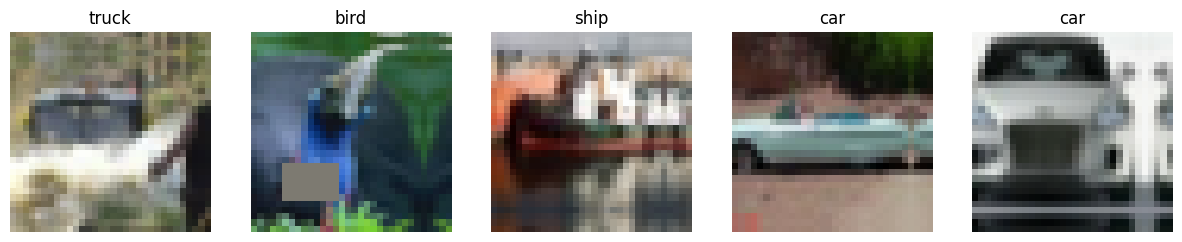

In [70]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# CIFAR-10 normalization
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

# Mild but effective augmentations
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([  # 50% chance to apply each
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    ], p=0.5),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    ], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),  # Very mild erasing
])

# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

# Load datasets
train_set = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_set = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

# Dataloaders
batch_size = 128
num_workers = 2

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True
)

test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# Visualization
import matplotlib.pyplot as plt
import numpy as np

def show_augmented_samples(loader, n=5):
    images, labels = next(iter(loader))
    classes = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img * CIFAR_STD + CIFAR_MEAN, 0, 1)  # Unnormalize
        plt.imshow(img)
        plt.title(classes[labels[i].item()])
        plt.axis('off')
    plt.show()

show_augmented_samples(train_loader)

## Training Loop

In [71]:
from timm.data.mixup import Mixup

mixup_fn = Mixup(
    mixup_alpha=0.8,
    cutmix_alpha=1.0,
    prob=0.5,  # 50% chance of applying mixup or cutmix
    switch_prob=0.5,  # Equal chance of mixup vs cutmix
    label_smoothing=0.1,
    num_classes=10
)

In [100]:
import torch
import torch.nn as nn
import math
from timm.optim import AdamW
from tqdm.notebook import tqdm
import wandb

def train_model(
    # Model architecture
    depth=6,
    dropout=0.1,
    mlp_ratio=4,
    num_patches=4,
    embed_dim=512,
    # Training hyperparameters
    epochs=50,
    lr=3e-4,
    weight_decay=0.05,
    pos_enc = '1d_learned',
    # Data
    train_loader=None,
    test_loader=None,
    # Augmentation
    mixup_fn=None,
    # WandB parameters
    wandb_project="diff-vision-transformers-cifar10",
    wandb_entity=None,
    wandb_name=None,
):
    # Initialize wandb
    wandb.init(
        project=wandb_project,
        entity=wandb_entity,
        name=wandb_name,
        config={
            "depth": depth,
            "dropout": dropout,
            "mlp_ratio": mlp_ratio,
            "num_patches": num_patches,
            "embed_dim": embed_dim,
            "epochs": epochs,
            "lr": lr,
            "weight_decay": weight_decay,
        }
    )

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Model initialization
    model = VisionTransformer(
        img_size=32,
        patch_size=32 // num_patches,
        num_classes=10,
        embed_dim=embed_dim,
        depth=depth,
        mlp_ratio=mlp_ratio,
        dropout=dropout,
        pos_embed_type=pos_enc
    ).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Custom soft cross entropy for mixup
    def soft_cross_entropy(pred, soft_targets):
        logsoftmax = nn.LogSoftmax(dim=1)
        return torch.mean(torch.sum(-soft_targets * logsoftmax(pred), dim=1))

    # LR scheduling: Warmup (5 epochs) + Cosine decay
    warmup_epochs = 5

    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return 0.1 + 0.9 * (epoch / warmup_epochs)  # Linear warmup
        else:
            # Cosine decay after warmup
            progress = (epoch - warmup_epochs) / (epochs - warmup_epochs)
            return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Training loop
    best_acc = 0.0
    best_model_path = f"best_model_{wandb.run.id}.pth"
    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            # Apply mixup/cutmix if available
            if mixup_fn is not None:
                mixed_images, mixed_labels = mixup_fn(images, labels)
                images = mixed_images

                # Forward pass
                outputs = model(images)

                # Handle mixup labels which are now one-hot encoded
                loss = soft_cross_entropy(outputs, mixed_labels)

                # For accuracy tracking with mixup (approximate)
                _, predicted = torch.max(outputs.data, 1)
                _, targets_max = torch.max(mixed_labels, dim=1)
                total_train += labels.size(0)
                correct_train += (predicted == targets_max).sum().item()
            else:
                # Forward pass without mixup
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Standard accuracy calculation
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # Metrics
            train_loss += loss.item()

        # Update LR
        scheduler.step()

        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Test/Validation
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = 100 * correct_test / total_test

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), best_model_path)

        # Track best loss
        if test_loss < best_loss:
            best_loss = test_loss

        # Log metrics
        wandb.log({
            "epoch": epoch,
            "train/loss": train_loss,
            "train/accuracy": train_acc,
            "test/loss": test_loss,
            "test/accuracy": test_acc,
            "lr": scheduler.get_last_lr()[0]
        })

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # Final evaluation with best model
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    correct_test = 0
    total_test = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Calculate test loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    print(f'\nFinal Test Results:')
    print(f'Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%')

    # Log final test metrics
    wandb.log({
        "test/loss": avg_test_loss,
        "test/accuracy": test_accuracy
    })

    # Add summary metrics
    wandb.run.summary["best_test_loss"] = best_loss
    wandb.run.summary["best_test_accuracy"] = best_acc
    wandb.run.summary["final_test_accuracy"] = test_accuracy

    wandb.finish()
    return best_acc / 100

In [73]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [74]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
cfg = {
    # Architecture
    'depth': 6,
    'dropout': 0.1,          # Reduced from 0.3 (fixes over-regularization)
    'mlp_ratio': 4,
    'num_patches': 8,        # 8x8 patches for 32x32 images
    'embed_dim': 192,        # Balanced capacity

    # Optimization
    'lr': 1e-3,              # Kept stable (from your best config)
    'weight_decay': 0.05,    # Reduced from 8e-3 (less aggressive)

    # Data Augmentation (critical fix)
    # 'augmentation': 'rand-m3-mstd0.5',  # Softer than before
    # 'translate_pct': 0.05,   # Minimal translations
}

# Train the model
for embedding_type in ["none", "2d_learned", "sinusoidal", "none"]:
    train_model(**cfg, train_loader=train_loader, test_loader=test_loader, epochs=50)

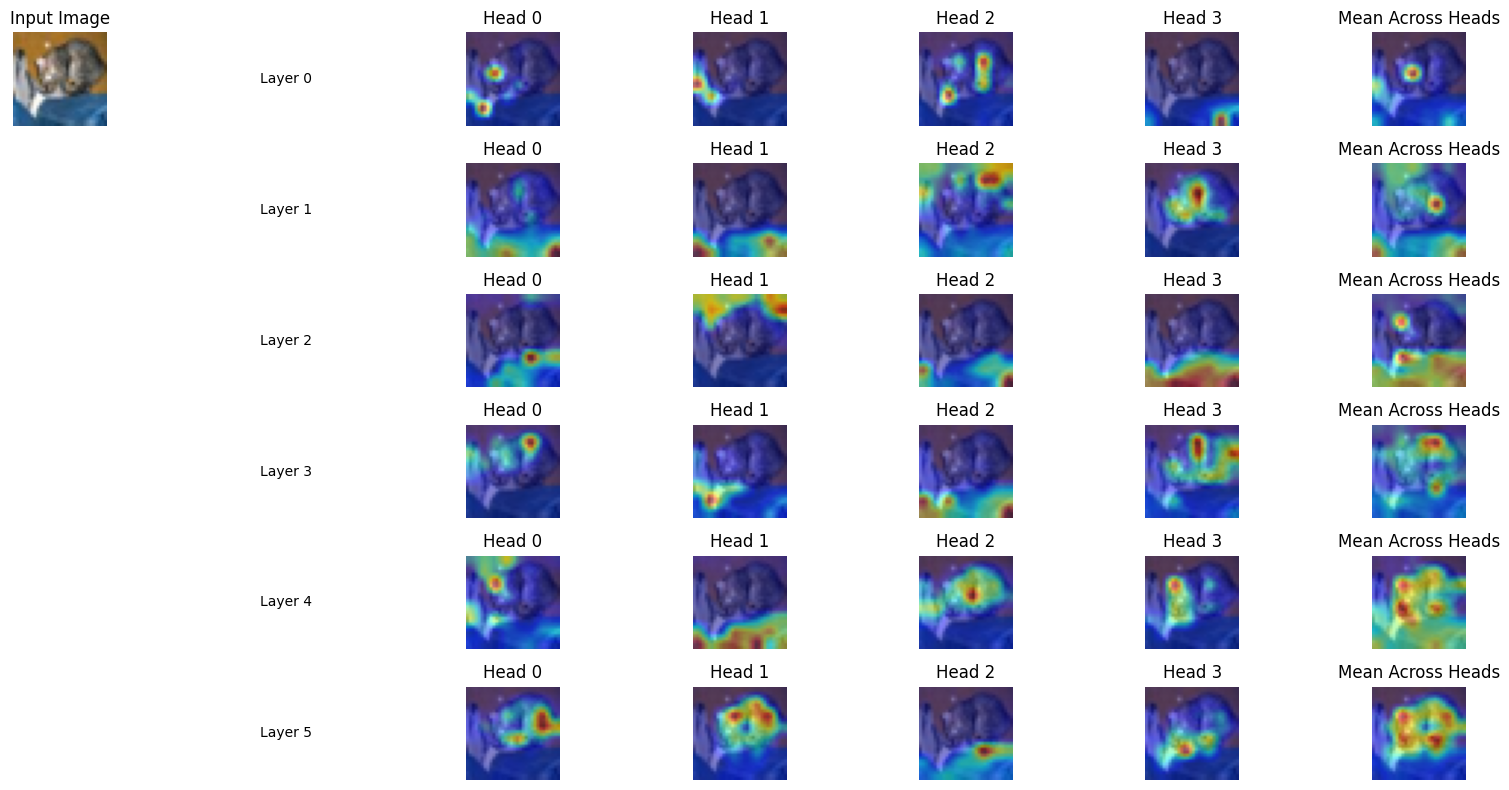

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import interpolate

num_patches=8
model = VisionTransformer(
    img_size=32,
    patch_size=32 // num_patches,
    num_classes=10,
    embed_dim=192,
    depth=6,
    mlp_ratio=4,
    dropout=0.1,
    pos_embed_type='1d_learned'
).to(device)
model.load_state_dict(torch.load('best_model_ye4owcmg.pth'))

def visualize_attention(attention_maps, images, patch_size=4, num_heads_to_show=4):
    """
    Args:
        attention_maps: List of attention matrices from all layers
                       Each of shape [batch_size, num_heads, n, n]
        images: Original images tensor [batch_size, 3, H, W]
        patch_size: Size of patches used in ViT
        num_heads_to_show: Number of heads to display per layer
    """
    # Select first image in batch
    img = images[0].cpu()
    attn_maps = [attn[0] for attn in attention_maps]  # Get first in batch

    # Unnormalize image
    img = img * torch.tensor(CIFAR_STD).view(3,1,1) + torch.tensor(CIFAR_MEAN).view(3,1,1)
    img = img.permute(1, 2, 0).numpy()

    # Create figure - add extra column for mean attention
    fig = plt.figure(figsize=(16, 8))
    grid = plt.GridSpec(len(attn_maps), num_heads_to_show + 3, figure=fig)  # +3 for image, layer label, and mean

    for layer_idx, attn in enumerate(attn_maps):
        # Get CLS attention for all heads [num_heads, n, n]
        cls_attentions = attn[:, 0, 1:]  # [num_heads, n-1]

        # Reshape to spatial dimensions
        grid_size = int(np.sqrt(cls_attentions.shape[-1]))
        cls_attentions = cls_attentions.reshape(-1, grid_size, grid_size)

        # Show original image for first layer
        if layer_idx == 0:
            ax = fig.add_subplot(grid[layer_idx, 0])
            ax.imshow(img)
            ax.set_title("Input Image")
            ax.axis('off')

        # Show layer header
        ax = fig.add_subplot(grid[layer_idx, 1])
        ax.text(0.5, 0.5, f"Layer {layer_idx}", ha='center', va='center')
        ax.axis('off')

        # Show attention heads (limited by num_heads_to_show)
        for head_idx in range(min(num_heads_to_show, attn.shape[0])):
            ax = fig.add_subplot(grid[layer_idx, head_idx + 2])

            # Upsample attention map to match image size
            attn_map = cls_attentions[head_idx].unsqueeze(0).unsqueeze(0)
            attn_map = interpolate(attn_map, scale_factor=patch_size, mode='bilinear')[0,0].cpu().numpy()

            ax.imshow(img)
            ax.imshow(attn_map, cmap='jet', alpha=0.5)
            ax.set_title(f"Head {head_idx}")
            ax.axis('off')

        # Show MEAN attention across all heads (new addition)
        ax = fig.add_subplot(grid[layer_idx, num_heads_to_show + 2])  # Last column

        # Calculate mean attention across heads
        mean_attn = cls_attentions.mean(0)  # [grid_size, grid_size]

        # Upsample mean attention
        mean_attn = mean_attn.unsqueeze(0).unsqueeze(0)  # [1, 1, grid_size, grid_size]
        mean_attn = interpolate(mean_attn, scale_factor=patch_size, mode='bilinear')[0,0].cpu().numpy()

        ax.imshow(img)
        ax.imshow(mean_attn, cmap='jet', alpha=0.5)
        ax.set_title("Mean Across Heads")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def get_attention_maps(model, images):
    """
    Extract attention maps from VisionTransformer with your exact architecture

    Args:
        model: VisionTransformer instance (with your TransformerEncoder)
        images: Input tensor [B, C, H, W]

    Returns:
        List of attention tensors [B, num_heads, num_patches+1, num_patches+1] per layer
    """
    model.eval()
    device = next(model.parameters()).device
    images = images.to(device)

    # Store original forward method
    original_forward = model.encoder.forward

    # Create list to collect attention maps
    attentions = []

    # Define patched forward to capture attention
    def wrapped_forward(z):
        nonlocal attentions
        for layer in model.encoder.layers:
            z, attn = layer(z)
            attentions.append(attn.detach().cpu())
        return z

    try:
        # Patch the forward method
        model.encoder.forward = wrapped_forward

        # Run forward pass (will populate attentions)
        with torch.no_grad():
            _ = model(images)

    finally:
        # Restore original forward
        model.encoder.forward = original_forward

    # Reshape to [num_layers, batch_size, num_heads, N+1, N+1]
    batch_size = images.shape[0]
    num_heads = attentions[0].shape[1] if len(attentions) > 0 else 0
    num_patches = attentions[0].shape[-1] - 1 if len(attentions) > 0 else 0

    # Stack and reshape
    if len(attentions) > 0:
        attentions = torch.stack(attentions)  # [L*B, heads, N+1, N+1]
        attentions = attentions.view(
            len(model.encoder.layers),  # L
            batch_size,
            num_heads,
            num_patches + 1,
            num_patches + 1
        )

    return attentions

# def get_attention_maps(model, images):
#     """Safely extract attention maps from modified ViT model

#     Args:
#         model: Your ViT model with attention storage capability
#         images: Input tensor of shape [B, C, H, W]

#     Returns:
#         List of attention matrices from all layers, each of shape [B, num_heads, n, n]
#     """
#     model.eval()

#     # Clear any previous attention maps
#     if hasattr(model.encoder, 'attentions'):
#         model.encoder.attentions = []

#     # Forward pass to populate attention maps
#     with torch.no_grad():
#         _ = model(images)

#     # Verify we captured attention maps
#     if not hasattr(model.encoder, 'attentions'):
#         raise ValueError("Model encoder doesn't have attentions attribute. "
#                         "Did you modify MultiHeadAttention to store attention?")

#     if len(model.encoder.attentions) == 0:
#         raise RuntimeError("No attention maps captured. Check if "
#                          "you're properly storing in forward pass.")

#     return model.encoder.attentions

# Get sample batch
images, labels = next(iter(test_loader))
images = images[:1].to(device)  # Just first image

# Get attention maps
attention_maps = get_attention_maps(model, images)

# Visualize
visualize_attention(attention_maps, images, patch_size=model.patch_embed.patch_size)

Parameter containing:
tensor([[[-5.2336e-01, -6.7817e-01,  7.4226e-01,  ...,  8.8670e-02,
          -4.5594e-01, -8.8632e-03],
         [ 7.5625e-01,  9.2415e-01,  6.5906e-01,  ..., -1.1131e+00,
           1.0474e+00,  1.7951e-01],
         [-5.8975e-01,  1.4446e-01, -3.9983e-01,  ..., -2.3080e-01,
          -4.1117e-01, -4.0004e-01],
         ...,
         [-3.6401e-01,  2.2660e-01,  3.1584e-01,  ..., -7.2479e-01,
          -1.5997e-01,  7.2561e-01],
         [ 5.3479e-01, -9.3441e-04,  4.2867e-01,  ..., -5.1899e-01,
          -3.7879e-01, -5.5094e-01],
         [ 1.3477e-01, -3.4792e-01,  4.6092e-02,  ..., -9.4727e-01,
          -7.2620e-01,  9.7704e-01]]], device='cuda:0', requires_grad=True)


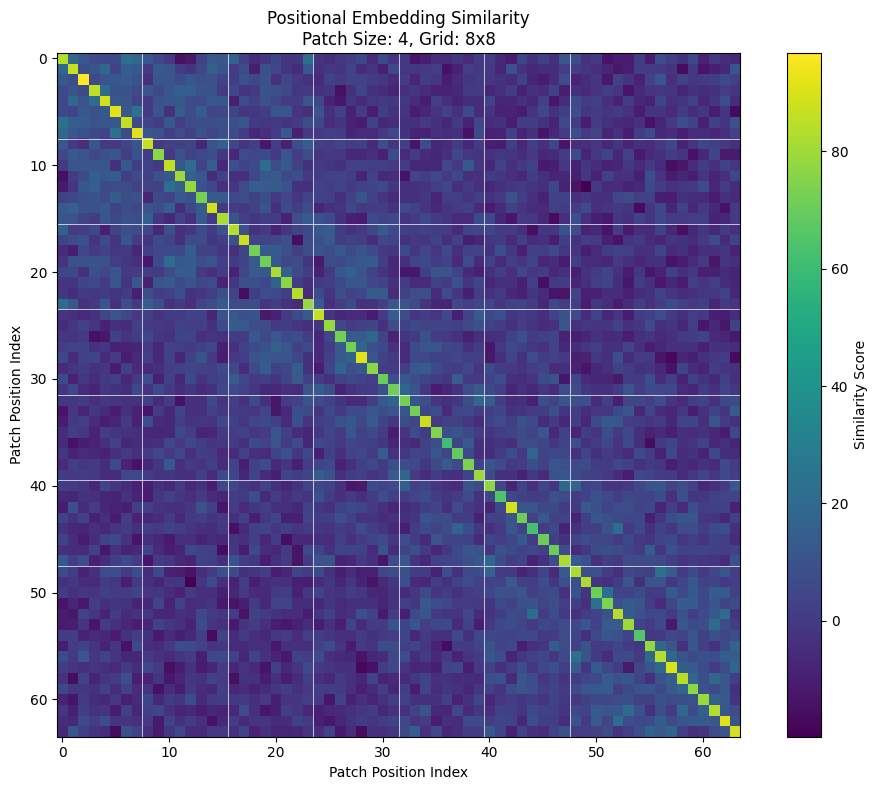

In [112]:
import matplotlib.pyplot as plt
import torch

def visualize_positional_similarity(model):
    # Get positional embeddings (including CLS token)
    pos_embed = model.patch_embed.pos_embed  # [1, num_patches+1, embed_dim]
    print(pos_embed)
    # Remove CLS token position embedding
    patch_pos_embed = pos_embed[:, 1:, :]  # [1, num_patches, embed_dim]

    # Calculate similarity matrix (dot product between all position embeddings)
    similarity = torch.mm(patch_pos_embed.squeeze(0),
                         patch_pos_embed.squeeze(0).T)  # [num_patches, num_patches]

    # Convert to numpy for visualization
    similarity = similarity.detach().cpu().numpy()

    # Create visualization
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity, cmap='viridis')
    plt.colorbar(label='Similarity Score')

    # Add labels and title
    num_patches = patch_pos_embed.shape[1]
    patch_size = model.patch_embed.patch_size
    img_size = model.patch_embed.img_size
    grid_size = img_size // patch_size

    plt.title(f"Positional Embedding Similarity\n"
              f"Patch Size: {patch_size}, Grid: {grid_size}x{grid_size}")
    plt.xlabel("Patch Position Index")
    plt.ylabel("Patch Position Index")

    # Add grid lines
    for i in range(grid_size-1):
        plt.axvline(i*grid_size - 0.5, color='white', linewidth=0.5)
        plt.axhline(i*grid_size - 0.5, color='white', linewidth=0.5)

    plt.tight_layout()
    plt.show()

# Usage
# print(model.patch_embed.pos_embed_type)
visualize_positional_similarity(model)